In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
import binarytree as bt

In [30]:
#Read in training data and format it
def setup_dataframes():
    df = pd.read_csv('MM_game_data.csv')
    df = df[df['YEAR'] >= 2013]
    df = df[df['YEAR'] <= 2023]
    np.unique(df['YEAR'])
    games = df.drop(['ROUND'], axis=1)
    
    df = pd.read_csv('cbb.csv')
    df = df[df['SEED'] > 0]
    df = df[df['YEAR'] <= 2023]
    teams = df.drop(['CONF', 'POSTSEASON', 'SEED'], axis=1)
    
    teams2024 = get_2024_data()
    teams2024.columns = teams.columns
    teams = pd.concat([teams, teams2024])
    
    rv = np.floor(np.random.rand(len(games))*2)
    
    return (games,teams,rv)

In [31]:
#Gets data for team from name and year
def get_team_data(team, year):
    all_years = teams.loc[teams['TEAM'] == team]
    specific_year = all_years.loc[all_years['YEAR'] == year]
    return specific_year

In [32]:
#Format the game data and randomly assign order (since inner was always first before)
def assemble_game_data():
    game_data = np.zeros(shape=(len(games), 38))
    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        if rv[i] == 0:
            game_data[i] = np.hstack([wdata, ldata])
        else:
            game_data[i] = np.hstack([ldata, wdata])
    return game_data

In [33]:
#Determine point differential for all games
def assemble_response_data():
    score_diff = []
    for i in range(0,len(games)):
        if rv[i] == 0:
            score_diff.append(games.iloc[i]['WSCORE'] - games.iloc[i]['LSCORE'])
        else:
            score_diff.append(games.iloc[i]['LSCORE'] - games.iloc[i]['WSCORE'])
    return score_diff

In [34]:
#Throw message if names don't match beteen datasets
def get_invalid_team_names():
    wrong_names = []

    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR'])
        if wdata.empty:
            wrong_names.append(games.iloc[i]['WTEAM'])
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR'])
        if ldata.empty:
            wrong_names.append(games.iloc[i]['LTEAM'])
    return np.unique(wrong_names)

In [59]:
#Use model and 2 team names to predict winner
def pred_winner(name1, name2, model, year):
    team1 = get_team_data(name1, year).drop(['TEAM', 'YEAR'], axis=1)
    if (team1.empty):
        print(name1)
    team2 = get_team_data(name2, year).drop(['TEAM', 'YEAR'], axis=1)
    if (team2.empty):
        print(name2)
    data = np.hstack([team1, team2])
    prob = model(data)[:,1]
    if prob > 0.5:
        return name1, prob
    else:
        return name2, 1-prob

In [36]:
#Sets up tree for a bracket based off default bracket design
def create_game_bracket(year):
    if (year == 2023):
        games = ["Finale", "FF1", "FF2", "EES", "EEE", "EEM", "EEW", "SSS1", "SSS2", "SSE1", "SSE2", "SSM1", "SSM2", "SSW1", "SSW2",
            "R2S1", "R2S2", "R2S3", "R2S4", "R2E1", "R2E2", "R2E3", "R2E4", "R2M1", "R2M2", "R2M3", "R2M4", "R2W1", "R2W2", 
            "R2W3", "R2W4", "R1S1", "R1S2", "R1S3", "R1S4", "R1S5", "R1S6", "R1S7", "R1S8", "R1E1", "R1E2", "R1E3", "R1E4", 
            "R1E5", "R1E6", "R1E7", "R1E8", "R1M1", "R1M2", "R1M3", "R1M4", "R1M5", "R1M6", "R1M7", "R1M8", "R1W1", "R1W2", 
            "R1W3", "R1W4", "R1W5", "R1W6", "R1W7", "R1W8", None, "FFS", None, None, None, None, None, None, None, None, None,
            None, None, None, None, None, None, "FFE", None, None, None, None, None, None, None, None, None, None, None, None, 
            None, None, None, None, None, None, None, None, None, None, None, "FFM", None, None, None, None, None, None, None,
            None, None, None, None, None, None, None, None,"FFW"]
    elif (year == 2024):
        games = ["Finale", "FF1", "FF2", "EEE", "EEW", "EES", "EEM", "SSE1", "SSE2", "SSW1", "SSW2", "SSs1", "SSS2", "SSM1", "SSM2",
            "R2E1", "R2E2", "R2E3", "R2E4", "R2W1", "R2W2", "R2W3", "R2W4", "R2S1", "R2S2", "R2S3", "R2S4", "R2M1", "R2M2", 
            "R2M3", "R2M4", "R1E1", "R1E2", "R1E3", "R1E4", "R1E5", "R1E6", "R1E7", "R1E8", "R1W1", "R1W2", "R1W3", "R1W4", 
            "R1W5", "R1W6", "R1W7", "R1W8", "R1S1", "R1S2", "R1S3", "R1S4", "R1S5", "R1S6", "R1S7", "R1S8", "R1M1", "R1M2", 
            "R1M3", "R1M4", "R1M5", "R1M6", "R1M7", "R1M8", None, None, None, None, None, None, None, None, None, None, None,
            None, None, None, None, None, None, "FFE", None, None, None, None, None, None, None, None, None, None, None, None, 
            None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, "FFW", None, None, None,
            "FFS", None, None, None, None, None, None, None, None, None, None, None, "FFM"]
    
    tree = bt.build(games)
    return tree

In [37]:
#Recursively calls through game tree to predict winners
def process_bracket_tree(node, model, year):
    df = pd.read_csv(str(year) + 'bracket.csv')
    numlist = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
    
    if (node.left == None) and (node.right == None):
        if node.value[:2] == "FF":
            t1 = get_team(True, node.value[2], 0, df)
            t2 = get_team(True, node.value[2], 1, df)
            (winner, prob) = pred_winner(t1, t2, model, year)
            node.value = str(node.value) + " " + str(winner) + " " + str(float(prob))
            return winner
        else:
            division = node.value[2]
            gameno = node.value[3]
            t1 = get_team(False, division, numlist[2*int(gameno) - 2], df)
            t2 = get_team(False, division, numlist[2*int(gameno)-1], df)
            (winner, prob) = pred_winner(t1, t2, model, year)
            node.value = str(node.value) + " " + str(winner) + " " + str(float(prob))
            return winner
    elif (node.left == None):
        t1 = get_team(False, node.value[2], numlist[2*int(node.value[3]) - 2], df)
        t2 = process_bracket_tree(node.right, model, year)
        (winner, prob) = pred_winner(t1, t2, model, year)
        node.value = str(node.value) + " " + str(winner) + " " + str(float(prob))
        return winner
    else:
        t1 = process_bracket_tree(node.left, model, year)
        t2 = process_bracket_tree(node.right, model, year)
        (winner, prob) = pred_winner(t1, t2, model, year)
        node.value = str(node.value) + " " + str(winner) + " " + str(float(prob))
        return winner

In [38]:
#Decodes bracket info to find team names for each game
def get_team(ff, division, number, df):
    if ff:
        if division == "E":
            teams = df[(df["Division"] == "East") & (df["Seed"] == "FF")]["Team"]
            return teams.iloc[number]
        elif division == "S":
            teams = df[(df["Division"] == "South") & (df["Seed"] == "FF")]["Team"]
            return teams.iloc[number]
        elif division == "M":
            teams = df[(df["Division"] == "Midwest") & (df["Seed"] == "FF")]["Team"]
            return teams.iloc[number]
        elif division == "W":
            teams = df[(df["Division"] == "West") & (df["Seed"] == "FF")]["Team"]
            return teams.iloc[number]
    else:
        if division == "E":
            teams = df[(df["Division"] == "East") & (df["Seed"] == str(number))]["Team"]
            return teams.iloc[0]
        elif division == "S":
            teams = df[(df["Division"] == "South") & (df["Seed"] == str(number))]["Team"]
            return teams.iloc[0]
        elif division == "M":
            teams = df[(df["Division"] == "Midwest") & (df["Seed"] == str(number))]["Team"]
            return teams.iloc[0]
        elif division == "W":
            teams = df[(df["Division"] == "West") & (df["Seed"] == str(number))]["Team"]
            return teams.iloc[0]
        

In [39]:
def get_2024_data():
    dfa = pd.read_csv('2024_team_results.csv')
    dfb = pd.read_csv('2024_fffinal.csv')
    
    games = []
    wins = []
    for record in dfa["record"]:
        [w,l] = record.split('-')
        games.append(int(w)+int(l))
        wins.append(int(w))
    dfa.insert(3, "games", games)
    dfa.insert(4, "wins", wins)
    
    df = dfa.merge(dfb, on="TeamName")
    dfb = dfb.drop(["TeamName"], axis=1)
    df.columns = dfa.columns.append(dfb.columns)
    df = df[["TeamName", "games", "wins", "adjoe", "adjde", "barthag", "eFG%", "eFG% Def", "TO%", "TO% Def.", "OR%", "DR%", "FTR", 
             "FTR Def", "2p%", "2p%D", "3P%", "3pD%", "adjt", "WAB"]]
    df.insert(20,"Year", 2024)
    return df

In [40]:
#Set up all data
(games,teams,rv) = setup_dataframes()
game_data = assemble_game_data()
score_data = assemble_response_data()
X_train, X_test, y_train, y_test = train_test_split(game_data, score_data, test_size=0.2, random_state=1)

0.48534516086405144

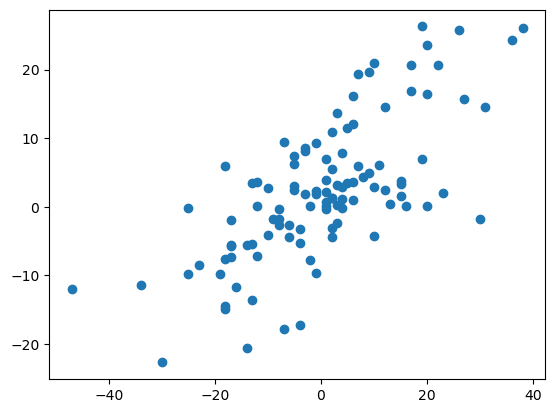

In [41]:
#Plot regression model to predict score differential
regr = MLPRegressor(random_state=1).fit(X_train, y_train)

pred = regr.predict(X_test)
plt.scatter(y_test, pred)
regr.score(X_test, y_test)

In [42]:
#Set up dataframe for just win/loss
win_data = (np.sign(score_data) + 1)/2

In [43]:
#NN model to predict winner
layers = [tf.keras.Input(shape=(None,38)), Dense(1000, activation="relu"), Dropout(0.1), Dense(500, activation="relu"), Dropout(0.2), Dense(250, activation="relu"), Dense(2, activation="softmax")]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 1000)        39000     
                                                                 
 dropout_2 (Dropout)         (None, None, 1000)        0         
                                                                 
 dense_5 (Dense)             (None, None, 500)         500500    
                                                                 
 dropout_3 (Dropout)         (None, None, 500)         0         
                                                                 
 dense_6 (Dense)             (None, None, 250)         125250    
                                                                 
 dense_7 (Dense)             (None, None, 2)           502       
                                                                 
Total params: 665252 (2.54 MB)
Trainable params: 66525

In [44]:
#Train model
n_epochs = 50
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(game_data, win_data, epochs=n_epochs)

Epoch 1/50
17/17 [==============================] - 1s 9ms/step - loss: 6.1845 - accuracy: 0.4748
Epoch 2/50
17/17 [==============================] - 0s 7ms/step - loss: 1.2395 - accuracy: 0.5234
Epoch 3/50
17/17 [==============================] - 0s 7ms/step - loss: 0.8135 - accuracy: 0.5850
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.6430
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.7055 - accuracy: 0.6262
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.6712 - accuracy: 0.6280
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6094 - accuracy: 0.6710
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 0.6005 - accuracy: 0.6729
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.6093 - accuracy: 0.6785
Epoch 10/50
17/17 [==============================] - 0s 8ms/step - loss: 0.5880 - accuracy: 0.6748
Epoch 11/50
17/17 [

In [45]:
#Accuracy of NN model
pred = model(game_data)
confusion_matrix(win_data, np.round(pred[:,1]))

array([[254,  14],
       [121, 146]], dtype=int64)

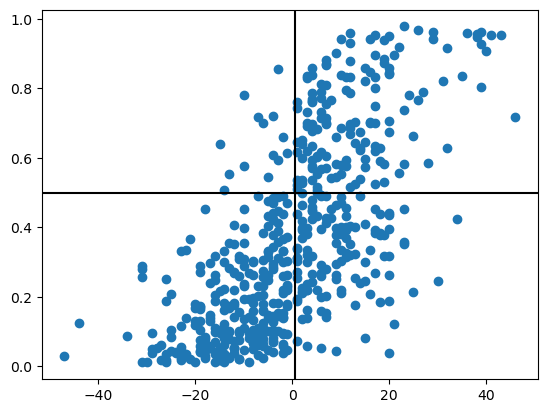

In [46]:
#Plot results of confidence based off of real score differential
plt.scatter(score_data, pred[:,1])
plt.axhline(0.5, c="black")
plt.axvline(0.5, c="black")

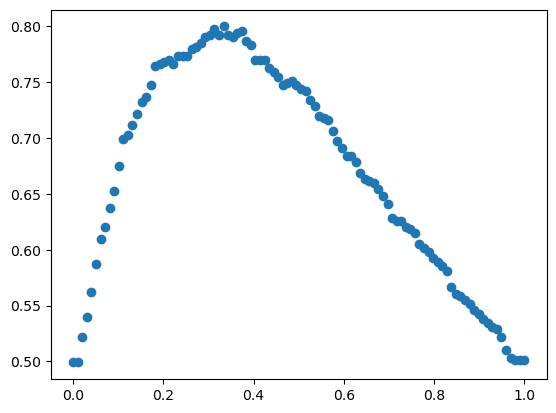

In [47]:
#Show accuracy for different cutoff values
cutoffs = np.linspace(0, 1, 100)
accuracies = []
for cutoff in cutoffs:
    pred1 = np.ceil(pred[:,1] - cutoff)
    accuracies.append(accuracy_score(win_data, pred1))
    
plt.scatter(cutoffs, accuracies)

In [62]:
#Process game tree an print results
root = create_game_bracket(2023)
process_bracket_tree(root, model, 2023)
root.values

['Finale UCLA 0.7438010573387146',
 'FF1 Marquette 0.7852082848548889',
 'FF2 UCLA 0.7554866075515747',
 'EES Arizona 0.5659370422363281',
 'EEE Marquette 0.8138452172279358',
 'EEM Texas 0.5783313512802124',
 'EEW UCLA 0.6718009114265442',
 'SSS1 San Diego St. 0.6641824245452881',
 'SSS2 Arizona 0.724709689617157',
 'SSE1 Tennessee 0.5044500231742859',
 'SSE2 Marquette 0.8568041324615479',
 'SSM1 Houston 0.5823094844818115',
 'SSM2 Texas 0.8072819113731384',
 'SSW1 Connecticut 0.7993199229240417',
 'SSW2 UCLA 0.7710621953010559',
 'R2S1 Alabama 0.7321369647979736',
 'R2S2 San Diego St. 0.7148672342300415',
 'R2S3 Baylor 0.7515977621078491',
 'R2S4 Arizona 0.8256812691688538',
 'R2E1 Florida Atlantic 0.6977580785751343',
 'R2E2 Tennessee 0.6332796812057495',
 'R2E3 Kansas St. 0.841166615486145',
 'R2E4 Marquette 0.9201217889785767',
 'R2M1 Houston 0.8087230920791626',
 'R2M2 Miami FL 0.5555132627487183',
 'R2M3 Xavier 0.8677008152008057',
 'R2M4 Texas 0.8451307415962219',
 'R2W1 Kansas

In [67]:
root = create_game_bracket(2024)
process_bracket_tree(root, model, 2024)
root.values

['Finale Houston 0.7038474678993225',
 'FF1 Connecticut 0.6859760284423828',
 'FF2 Houston 0.5377814769744873',
 'EEE Connecticut 0.5297466516494751',
 'EEW Arizona 0.814811110496521',
 'EES Houston 0.5835661888122559',
 'EEM Purdue 0.5355744957923889',
 'SSE1 Connecticut 0.5440858602523804',
 'SSE2 Iowa St. 0.7860674262046814',
 'SSW1 College of Charleston 0.5064811706542969',
 'SSW2 Arizona 0.6898006200790405',
 'SSs1 Houston 0.7444421648979187',
 'SSS2 Marquette 0.8159478306770325',
 'SSM1 Purdue 0.6018901467323303',
 'SSM2 Tennessee 0.6642013788223267',
 'R2E1 Connecticut 0.812140941619873',
 'R2E2 Auburn 0.8786900043487549',
 'R2E3 Illinois 0.7409008741378784',
 'R2E4 Iowa St. 0.8594235777854919',
 'R2W1 North Carolina 0.5470957159996033',
 'R2W2 College of Charleston 0.7221815586090088',
 'R2W3 Baylor 0.653510570526123',
 'R2W4 Arizona 0.825042188167572',
 'R2S1 Houston 0.8417925834655762',
 'R2S2 Duke 0.678154468536377',
 'R2S3 Kentucky 0.7504037618637085',
 'R2S4 Marquette 0.81